### А/В - тестирование. Финальный проект.

#### Цели исследования:

Проведение оценки результатов А/В-теста. Оценка корректности проведения теста и анализ его результатов.

#### Описание данных:

##### ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год.

##### Структура файла:

•	name — название маркетингового события;

•	regions — регионы, в которых будет проводиться рекламная кампания;

•	start_dt — дата начала кампании;

•	finish_dt — дата завершения кампании.

##### final_ab_new_users.csv — пользователи, зарегистрировавшиеся с 7 до 21 декабря 2020 года.

#### Структура файла:

•	user_id — идентификатор пользователя;

•	first_date — дата регистрации;

•	region — регион пользователя;

•	device — устройство, с которого происходила регистрация.

#### final_ab_events.csv — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

#### Структура файла:

•	user_id — идентификатор пользователя;

•	event_dt — дата и время события;

•	event_name — тип события;

•	details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

##### final_ab_participants.csv — таблица участников тестов.

#### Структура файла:

•	user_id — идентификатор пользователя;

•	ab_test — название теста;

•	group — группа пользователя.


#### 1. Загрузка и подготовка данных.

In [1]:
pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
import matplotlib.lines as mlines
import seaborn as sns
import datetime as dt
import scipy.stats as stats
from scipy import stats as st
import math as mth
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()
sns.set(style='whitegrid')
sns.set_palette('Set2')
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)


import plotly.io as pio
pio.renderers.default = "svg"
svg_renderer = pio.renderers["svg"]
svg_renderer.scale = 1.2
import plotly.graph_objs as go
from plotly import graph_objects as go
import plotly.express as px
import math
from statsmodels.stats.proportion import proportions_ztest
from datetime import datetime,timedelta

Загружаем файлы.

In [3]:
try:
    marketing_events = pd.read_csv('ab_project_marketing_events.csv')
    users = pd.read_csv('final_ab_new_users.csv')
    events = pd.read_csv('final_ab_events.csv')
    participants = pd.read_csv('final_ab_participants.csv')
except:
    marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
    users = pd.read_csv('/datasets/final_ab_new_users.csv')
    events = pd.read_csv('/datasets/final_ab_events.csv')
    participants = pd.read_csv('/datasets/final_ab_participants.csv')

Рассмотрим данные файла final_ab_events.csv - все события новых пользователей в период с 7 декабря по 4 января 2021 года.

Выводим первые 5 строк и общую информацию.

In [4]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [5]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


Проверяем на пропуски и дубликаты.

In [6]:
events.isnull().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

In [7]:
events.duplicated().sum()

0

Дубликатов не обнаружено. В столбце details обнаружено 377577 пропусков. Рассмотрим пропущенные значения.

In [8]:
events_=events.groupby('event_name',as_index=False).agg(count_object=('details','count'))\
.sort_values(by='count_object',ascending=False)
events_.head()

,event_name,count_object
3,purchase,62740
0,login,0
1,product_cart,0
2,product_page,0


В колонке details содержатся дополнительные данные о событиях - стоимость покупки в долларах. Данные в столбце есть только для события purchase -покупки. Для остальных событий в столбце details пропуски, так как на этапах просмотра карточек товаров, просмотра корзины покупки еще не совершались и пропуски вполне логичны. Оставляю их незаполненными.

Дату event_dt преобразуем из типа object в тип даты.

In [9]:
events['event_dt'] = pd.to_datetime(events['event_dt'])

In [10]:
events['event_dt_']=events['event_dt'].astype('datetime64[D]')

In [11]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
 4   event_dt_   440317 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 16.8+ MB


In [12]:
events

,user_id,event_dt,event_name,details,event_dt_
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07
...,...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN,2020-12-30
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN,2020-12-30
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN,2020-12-30
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN,2020-12-30


Рассмотрим данные файла final_ab_new_users.csv - все пользователи, зарегестрировавшиеся в интернет-магазине в период с 7 декабря по 21 декабря 2020 года.

Выводим первые 5 строк и общую информацию.

In [13]:
users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


Проверяем на наличие пропусков и дубликатов.

In [15]:
users.isnull().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [16]:
users.duplicated().sum()

0

Пропусков и дубликатов в датафрейме не обнаружено.

Дата first_date тип object. Приводим ее к типу даты.

In [17]:
users['first_date'] = pd.to_datetime(users['first_date'])

In [18]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


Рассмотрим данные файла final_ab_participants.csv - таблица участников теста.

In [19]:
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [20]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [21]:
participants.isnull().sum()

user_id    0
group      0
ab_test    0
dtype: int64

In [22]:
participants.duplicated().sum()

0

В датафрейме пропуски и дубликаты не обнаружены. Нет необходимости в преобразовании типа данных.

Рассмотрим данные таблицы ab_project_marketing_events - календарь маркетинговых событий на 2020 год.

In [23]:
marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [24]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [25]:
marketing_events.isnull().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [26]:
marketing_events.duplicated().sum()

0

Пропусков и дубликатов не обнаружено. Столбцы start_dt и finish_dt нужно преобразовать из типа object в тип даты.

In [27]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

In [28]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


****Выводы:****


*****Проверены данные на предмет дубликатов и пропусков. Дубликатов не выявлено. Выявлены пропущенные данные в столбце details в таблице events. Их оставляю незаполненные, так как пропущенные данные в стобце относятся только к событиям не относящимся к покупкам. В таблицах в столбцах с датами заменен тип данных object на тип даты.*****

#### 2. Оценка корректности проведения теста.

Выделяем пользователей, участвующих в тесте и проверяем период набора пользователей в тест е его соответствие требованиям технического задания.

In [29]:
users['first_date'].min()

Timestamp('2020-12-07 00:00:00')

In [30]:
users['first_date'].max()

Timestamp('2020-12-23 00:00:00')

In [31]:
users['week']=users['first_date'].dt.isocalendar().week

In [32]:
users['week']=users['week'].astype(int)

In [33]:
events['event_dt'].min()

Timestamp('2020-12-07 00:00:33')

In [34]:
events['event_dt'].max()

Timestamp('2020-12-30 23:36:33')

По техническому заданию дата запуска теста - 07.12.2020. Дата остановки теста - 04.01.2021. Дата остановки набора новых пользователей - 21.12.2020.

Даты регистрации пользователей с 07.12.2020 по 23.12.2020. Даты событий новых пользователей с 07.12.2020 по 30.12.2020. 

В части регистрации новых пользователей выявлено несоответствие техническому заданию - данные по регистрации новых пользователей даны по 23.12.2020, а по техническому заданию набор новых пользователей в группы теста должна закончится 21.12.2020. В части даты остановки теста также выявлено несоответствие техническому заданию - дата остановки теста по техническому заданию 04.01.2021, а данные для проверки результатов тестирования даны только за период по 30.12.2020.

Так как дата остановки набора новых пользователей по техническому заданию 21.12.2020, то пользователей, зарегистрировавшихся в период с 22.12.2020 по 23.12.2020 нужно будет исключить. Но проверим даты интересующего нас recommender_system test.

In [35]:
test_users = pd.merge(users,participants, on = 'user_id')

In [36]:
test_recommender=test_users.query('ab_test == "recommender_system_test"')

In [37]:
test_recommender['first_date'].min()

Timestamp('2020-12-07 00:00:00')

In [38]:
test_recommender['first_date'].max()

Timestamp('2020-12-21 00:00:00')

In [39]:
test_users['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

In [40]:
test_interface=test_users.query('ab_test=="interface_eu_test"')

In [41]:
test_interface['first_date'].min()

Timestamp('2020-12-07 00:00:00')

In [42]:
test_interface['first_date'].max()

Timestamp('2020-12-23 00:00:00')

Оба конкурирующих теста проводятся одновременно. Есть данные пользователей, зарегистрированных в test_interface после 21.12.2020. Мы будем рассматривать данные только теста recommende_system_test, по условиям технического задания после 21.12.2020 пользователей в тест уже не должны были регистрировать. В тесте recommender_system_test пользователей, зарегистрированных после 21.12.2020 нет.

In [43]:
test_max=pd.to_datetime('2020-12-21')

In [44]:
test_recommender_=test_recommender.query('first_date<=@test_max')

In [45]:
test_recommender_['first_date'].max()

Timestamp('2020-12-21 00:00:00')

Рассмотрим регион регистрации пользователей: все ли попавшие а тест пользователи представляют целевой регион и составляет ли общее количество пользователей из целевого региона 15% от общего числа пользователей из целевого региона, зарегистрированных в период набора пользователей в тест.

In [46]:
test_users_=test_users.query('first_date<@test_max')

In [47]:
region_users = test_users_.groupby('region').agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'Участники'})
region_users['% участников'] = (region_users['Участники'] / region_users['Участники'].sum()).round(2)
region_users.sort_values(by = 'Участники', ascending = False)

,Участники,% участников
region,,
EU,13630,0.98
N.America,193,0.01
APAC,66,0.00
CIS,51,0.00


In [48]:
test_recommender_region = test_recommender_.groupby('region').agg({'user_id': 'nunique'})
test_recommender_region['% '] = (test_recommender_region['user_id'] / test_recommender_region['user_id'].sum()).round(2)
test_recommender_region.sort_values(by = 'user_id', ascending = False)

,user_id,%
region,,
EU,6351,0.95
N.America,223,0.03
APAC,72,0.01
CIS,55,0.01


In [49]:
test_recommender_eu=test_recommender_.query('region=="EU"').shape[0]
test_recommender_eu

6351

In [50]:
test_users_1=test_users_.query('region=="EU"')['user_id'].nunique()
test_users_1

13630

In [51]:
round(test_recommender_eu/test_users_1*100,2)

46.6

В тест test_recommender попало 46,6% пользователей из региона EU от всех пользователей из региона EU.

In [52]:
start_date_users = pd.to_datetime('2020-12-07')
finish_date_users=pd.to_datetime('2020-12-22')

In [53]:
test_recommender_eu_1=test_recommender_.query('first_date >= @start_date_users and first_date<@finish_date_users and region=="EU"').shape[0]
eu_users = users.query('region == "EU" and first_date >= @start_date_users and first_date < @finish_date_users').shape[0]
round(test_recommender_eu/eu_users,2)

0.15

Из всех зарегистрировавшихся пользователе в интернет-магазине в период с 7 по 22 декабря 2020 года, 98% пользователей относятся к региону EU, остальные к другим регионам. 

В группе пользователей, учавствующих в recommender_system_test, 6351 или 95% пользователей, зарегистрировавшихся с 7 по 22 декабря 2020 года, относятся к EU региону. 

Проведена проверка соотношения участников теста recommender_system_test из EU к новым пользователям системы из EU в период набора новых пользователей в тест. Это составляет 15% от всех пользователей из данного региона, что соответствует условиям технического задания, где ожидаемое количество участников теста - 15% новых пользователей из региона EU.

Рассмотрим динамику набора пользователей в группы теста и проверим равномерность распределения пользователей по группам теста и корректность их формирования.

In [54]:
test_recommender_['first_date'].value_counts()

2020-12-21    723
2020-12-14    665
2020-12-07    645
2020-12-13    581
2020-12-12    489
2020-12-20    485
2020-12-19    423
2020-12-18    397
2020-12-10    391
2020-12-08    364
2020-12-15    359
2020-12-17    359
2020-12-16    285
2020-12-11    277
2020-12-09    258
Name: first_date, dtype: int64

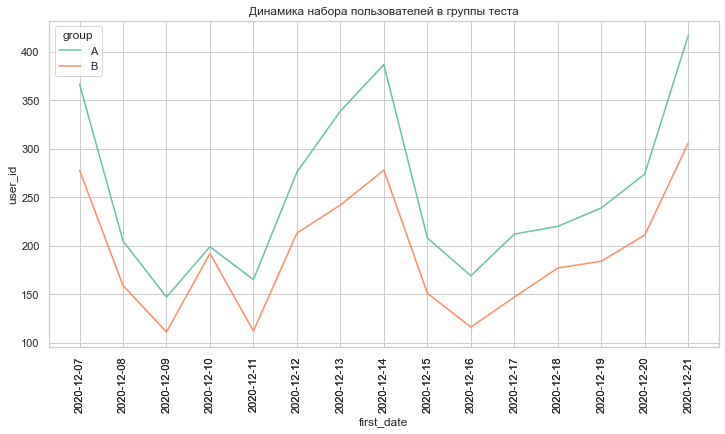

In [55]:
test_recommender_1=test_recommender_.groupby(['first_date','group'])['user_id'].count().reset_index()

plt.figure(figsize=(12,6))
sns.set_style("whitegrid")
ax=sns.lineplot(data=test_recommender_1,x='first_date',y='user_id',hue='group')
ax.set_xticks(test_recommender_1['first_date'])
plt.xticks(rotation=90)
ax.set_title('Динамика набора пользователей в группы теста')
plt.show()

Набор пользователей в группы теста распределилось следующим образом: наибольшее количество пользователей пришли в 1-й и 8-й день набора пользователей в группы теста (07.12.2020 в группу А пришло 367 пользователей, в группу В -278, 14.12.2020 - 387 и 278 соответственно). Динамика прихода пользователей в группах А и В аналогична. В 1-й день наблюдается пик, далее снижение 09.12.2020 до 147 пользователей в группе А и 111 - в группе В. Далее небольшое всплеск на 10.12.2020, и снова снижение на 11.12.2020. Затем количество пользователей расчет и достигает максимума 14.12.2020, после чего идет резкое снижение и низкие значения - 16.12.2020 (169 - в группе А и  116 - в группе В). Далее идет рост набора в обоих группах.

In [56]:
test_recommender_1

,first_date,group,user_id
0,2020-12-07,A,367
1,2020-12-07,B,278
2,2020-12-08,A,205
3,2020-12-08,B,159
4,2020-12-09,A,147
5,2020-12-09,B,111
6,2020-12-10,A,199
7,2020-12-10,B,192
8,2020-12-11,A,165
9,2020-12-11,B,112


In [57]:
count_group=test_recommender_.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})
perc_A=round(test_recommender_.query('group=="A"')['user_id'].nunique()/test_recommender_['user_id'].nunique()*100,2)
perc_B=round(test_recommender_.query('group=="B"')['user_id'].nunique()/test_recommender_['user_id'].nunique()*100,2)
count_group['%']=[perc_A,perc_B]
count_group

user_id      %
ab_test                 group                
recommender_system_test A         3824  57.07
                        B         2877  42.93

Распределение пользователей между группами А и В в тесте неравномерно. В группу А входит 57.07% пользователей, в группу В - 42.93%.

Оценим недельную цикличность набора пользователей в группы.

In [58]:
test_recommender_week=test_recommender_.groupby(['week','group'])['user_id'].count().reset_index()
test_recommender_week

,week,group,user_id
0,50,A,1698
1,50,B,1307
2,51,A,1709
3,51,B,1264
4,52,A,417
5,52,B,306


В 51-ю неделю количество пришедших пользователей в группу А незначительно больше, чем в 50-ю. В группе В наоборот - в 51-ю неделю пришло пользователей немного меньше, чем в 50-ю.

Проверим, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно.

In [59]:
len(np.intersect1d(test_users.query('ab_test == "recommender_system_test"')['user_id'], test_users.query(
'ab_test == "interface_eu_test"')['user_id'], assume_unique = False))


1602

In [60]:
doubl_users=(np.intersect1d(test_users.query('ab_test == "recommender_system_test"')['user_id'], test_users.query(
'ab_test == "interface_eu_test"')['user_id']))


In [61]:
double_users=test_users.query('user_id in @doubl_users')

In [62]:
double_users_=double_users.groupby('group',as_index=False).agg(count_oblect=('group','count'))
double_users_

,group,count_oblect
0,A,1740
1,B,1464


In [63]:
double_users_1=double_users.groupby(['ab_test','group'])['user_id'].count().reset_index()
double_users_1

,ab_test,group,user_id
0,interface_eu_test,A,819
1,interface_eu_test,B,783
2,recommender_system_test,A,921
3,recommender_system_test,B,681


In [64]:
count_group

user_id      %
ab_test                 group                
recommender_system_test A         3824  57.07
                        B         2877  42.93

In [65]:
round(double_users.query('ab_test == "recommender_system_test" & group=="A"')['user_id'].nunique()/test_users.query('ab_test == "recommender_system_test" & group=="A"')['user_id'].nunique()*100,0)

24.0

In [66]:
round(double_users.query('ab_test == "interface_eu_test" & group=="B"')['user_id'].nunique()/test_users.query('ab_test == "recommender_system_test" & group=="B"')['user_id'].nunique()*100,0)

27.0

In [67]:
round(double_users.query('ab_test == "interface_eu_test" & group=="B"')['user_id'].nunique()/test_users.query('ab_test == "recommender_system_test" & group=="A"')['user_id'].nunique()*100,0)

20.0

In [68]:
round(double_users.query('ab_test == "interface_eu_test" & group=="B"')['user_id'].nunique()/test_users.query('ab_test == "recommender_system_test" & group=="A"')['user_id'].nunique()*100,0)

20.0

Количество пользователей, вошедших в оба теста в группе А и в группе В примерно одинаково относительно общего количества участников теста в каждой группе и составляет порядка 24%. Удалять их не буду, так как удаление такого большого количества участников теста значительно снизит исследуемую аудиторию, в то же время поскольку их количество в группах составляет примерно одинаковый %, предполагаю, что влияние этих пользователей на изменение основных метрик будет в обеих группах будет идентично.

Оценили, какую долю участники группы В конкурирующего теста занимают в группе В нашего теста и какую долю занимают участники группы В конкурирующего теста в группе А нашего теста. Проверка показала, что пользователи распределены равномерно: участники группы В конкурирующего теста в группе А нашего теста занимают 20%, и в группе В нашего теста также занимают 20%. Доли равны, поэтому мы можем говорить о сбалансированном влиянии группы В на наш тест и не исключать пользователей из пересечения.

In [69]:
len(np.intersect1d(test_recommender_.query('group == "A"')['user_id'], test_recommender_.query(
'group == "B"')['user_id'], assume_unique = False))

0

Выявлено пересечение с конкурирующим тестом -1602 пользователя. Не выявлено пользователей, участвующих в двух группах одновременно.

Проверим данные о пользовательской активности. Совпадают ли даты совершения событий участниками теста с датами проведения теста, согласно техническому заданию.

In [70]:
test_events = pd.merge(events,test_recommender_, on = 'user_id')

In [71]:
test_events['event_dt_'].min()

Timestamp('2020-12-07 00:00:00')

In [72]:
test_events['event_dt_'].max()

Timestamp('2020-12-30 00:00:00')

Согласно техническому заданию дата запуска теста - 07.12.2020, дата остановки 04.01.2021. Даты пользовательской активности не соответствуют техническому заданию - не хватает данных за период с 31.12.2020 по 04.01.2021.

Проверим все ли зарегистрированные пользователи прошли авторизацию и совершили переход по продуктовой воронке. Изучим пользователей, которые не совершили событий после регистрации.

In [73]:
test_events['user_id'].nunique()

3675

In [74]:
test_login=test_events.groupby('user_id').agg({'event_name': 'nunique'}).sort_values(by = 'event_name', ascending = False)
test_login

,event_name
user_id,
6627324ED71E6A4B,4
6166273FF727F34F,4
627AB20C63592344,4
6319E43AA9A5DF8E,4
637D21ED4BE05F81,4
...,...
D2A9C2B69B9F4574,1
3AE5E3EE2C8A8727,1
A8738C98EA4BB1A7,1


In [75]:
test_recommender_['user_id'].nunique()

6701

In [76]:
test_events['user_id'].nunique()

3675

Объединяю таблицы так, чтобы в новую таблицу вошли все зарегистрировавшиеся в тест новые пользователи, а не только пользователи совершившие какое-либо событие.

In [77]:
test_events_all=pd.merge(test_recommender_,events, on = 'user_id',how='left')

In [78]:
test_events_all['user_id'].nunique()

6701

Выделяю только тех пользователей, которые не совершили ни одного события, прошли только регистрацию на этапе набора новых пользователей в тест.

In [79]:
users_not_events=test_events_all[(test_events_all.event_name!='login') & (test_events_all.event_name!='product_cart')&(test_events_all.event_name!='product_page')&(test_events_all.event_name!='purchase')]

In [80]:
users_not_events

,user_id,first_date,region,device,week,group,ab_test,event_dt,event_name,details,event_dt_
2,E6DE857AFBDC6102,2020-12-07,EU,PC,50,B,recommender_system_test,NaT,NaN,NaN,NaT
50,16C69ED14DA9F4A8,2020-12-07,EU,PC,50,B,recommender_system_test,NaT,NaN,NaN,NaT
54,2420EA89BB4BB0EA,2020-12-07,EU,iPhone,50,A,recommender_system_test,NaT,NaN,NaN,NaT
55,4D851A41ECF4440F,2020-12-07,EU,Android,50,B,recommender_system_test,NaT,NaN,NaN,NaT
95,8EB0C7622C73BBA3,2020-12-07,EU,Android,50,A,recommender_system_test,NaT,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...
27611,1942FB76074AA16F,2020-12-20,EU,PC,51,B,recommender_system_test,NaT,NaN,NaN,NaT
27612,6670B7F8E44E51A9,2020-12-20,EU,Android,51,B,recommender_system_test,NaT,NaN,NaN,NaT
27665,FB99C8676FAF89A7,2020-12-20,EU,PC,51,B,recommender_system_test,NaT,NaN,NaN,NaT
27682,220B14060698D586,2020-12-20,EU,iPhone,51,B,recommender_system_test,NaT,NaN,NaN,NaT


In [81]:
users_not_events['user_id'].nunique()

3026

In [82]:
count_users_not_events=users_not_events.groupby('group').agg({'user_id': 'nunique'})
perc_A=round(users_not_events.query('group=="A"')['user_id'].nunique()/users_not_events['user_id'].nunique()*100,2)
perc_B=round(users_not_events.query('group=="B"')['user_id'].nunique()/users_not_events['user_id'].nunique()*100,2)
count_users_not_events['%']=[perc_A,perc_B]
count_users_not_events

,user_id,%
group,,
A,1077,35.59
B,1949,64.41


In [83]:
users_not_events.groupby('first_date').agg({'user_id':'nunique'}).sort_values(by='user_id',ascending=False)

,user_id
first_date,
2020-12-13,510
2020-12-12,372
2020-12-07,300
2020-12-10,292
2020-12-08,222
2020-12-21,213
2020-12-14,206
2020-12-11,164
2020-12-20,148


In [84]:
users_not_events.groupby(['first_date','group']).agg({'user_id':'nunique'}).sort_values(by='first_date')

user_id
first_date group         
2020-12-07 A          204
           B           96
2020-12-08 A          107
           B          115
2020-12-09 A           65
           B           26
2020-12-10 A          133
           B          159
2020-12-11 A           73
           B           91
2020-12-12 B          160
           A          212
2020-12-13 A          283
           B          227
2020-12-14 B          206
2020-12-15 B          119
2020-12-16 B           17
2020-12-17 B          108
2020-12-18 B          127
2020-12-19 B          137
2020-12-20 B          148
2020-12-21 B          213

In [85]:
users_not_events.groupby(['region','group']).agg({'user_id':'nunique'}).sort_values(by='user_id',ascending=False)

user_id
region    group         
EU        B         1840
          A         1030
N.America B           72
          A           32
CIS       B           19
APAC      B           18
          A            9
CIS       A            6

In [86]:
users_not_events.groupby(['device','group']).agg({'user_id':'nunique'}).sort_values(by='user_id',ascending=False)

user_id
device  group         
Android B          883
        A          475
PC      B          469
iPhone  B          413
PC      A          285
iPhone  A          214
Mac     B          184
        A          103

Не все зарегистрированные пользователи совершали события после регистрации и совершали переход по продуктовой воронке. Их количество 3026 уникальных пользователей. В группе А- 1077 (35.59%), в группе В -1949 (64.41%). Эти пользователи не войдут в итоговую таблицу, в которой будем проверять результаты тестирования, поэтому оставляю их без изменения.

По дате регистрации -наибольшее число пользователей, не совершивших ни одного события зарегистрировались 13.12.2020 -510, 12.12.2020 -372 - это 6-й и 7-й день регистрации и начала теста. 07.12.2020,10.12.2020.и 08.12.2020, то есть в начале теста также наблюдается большое количество пользователей, не совершивших ни одного события после регистрации - 300, 292, 222. 

Если рассматривать пользователей не совершавших события по группам теста, то наблюдается, что с 14.12.2020 и до даты окончания набора пользователей, не совершают события пользователи из группы В, до 14.12.2020 - попадали пользователи из обоих групп.

Посмотрим на количество пользователей и динамику их перехода от события к событию.

In [87]:
test_events['user_id'].nunique()

3675

In [88]:
test_events_=test_events.query('first_date >= @start_date_users and first_date<=@finish_date_users and region=="EU"')

In [89]:
test_events_['region'].value_counts()

EU    23420
Name: region, dtype: int64

In [90]:
test_events_['ab_test'].value_counts()

recommender_system_test    23420
Name: ab_test, dtype: int64

In [91]:
test_events_['user_id'].nunique()

3481

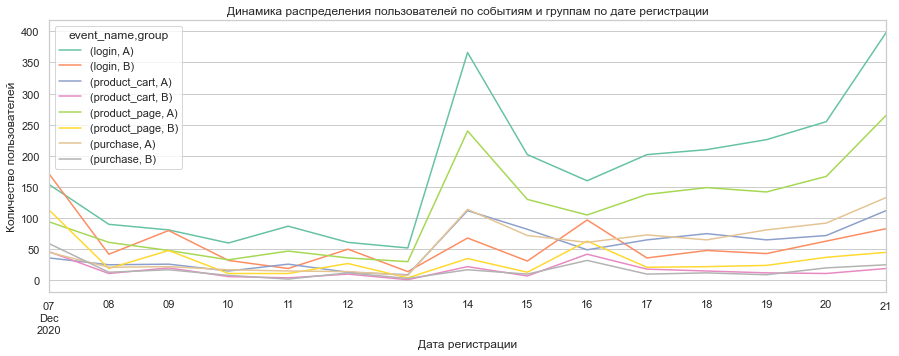

In [92]:
test_events_.pivot_table(
    index='first_date',  
    columns=['event_name','group'], 
    values='user_id',  
    aggfunc='nunique' 
).plot(figsize=(15, 5), grid=True)
plt.title('Динамика распределения пользователей по событиям и группам по дате регистрации')
plt.xlabel('Дата регистрации')
plt.ylabel('Количество пользователей')
plt.show()

In [93]:
test_events_.pivot_table(
    index='first_date',  
    columns=['group','event_name'], 
    values='user_id',  
    aggfunc='nunique' 
)


group          A                                        B                                   
event_name login product_cart product_page purchase login product_cart product_page purchase
first_date                                                                                  
2020-12-07   154           36           94       45   171           46          113       59
2020-12-08    90           25           61       21    42           11           19       13
2020-12-09    81           26           48       22    80           20           48       17
2020-12-10    60           15           33       17    32            6           11        8
2020-12-11    87           26           47       15    19            4           11        2
2020-12-12    61           13           36       14    50           10           27       12
2020-12-13    52            9           30        8    14            1            4        3
2020-12-14   366          112          240      114    68           22           35       17
2020-12-15   202           82          130       72    31            7           13       10
2020-12-16   160           49          105       61    97           42           63       32
2020-12-17   202           65          138       73    36           18           21       10
2020-12-18   210           75          149       65    48           15           22       12
2020-12-19   226           65          142       81    43           12           24        9
2020-12-20   255           72          167       92    63           11           37       20
2020-12-21   398          112          265      133    83           19           45       25

Событие login - наибольшее количество пользователей как в группе А, так и в группе В в первый день проведения теста - 07.12.2020 - 154 и 171 пользователя соответственно. Далее в группах наблюдается снижение активности и 13.12.2020 количество пользователей составляет 52 в группе А и 9 в группе В. С 14.12.2020 мы видим резкий рост в группе А 14.12.2020 и небольшой рост в группе В. Это 8-й день проведения теста, можно предположить недельную цикличность. В группе А с 15.12.2020 наблюдается снижение, но количество пользователей колеблется на достаточно высоком уровне - 202-255 и достигает максимума 21.12.2020 -398. В группе В 14.12.2020 произошел значительный рост - 112 и далее снижение, значения колеблются на уровне 49-82 до конца 2-й недели теста и  показывает рост 21.12.2020 -112.

Событие product_page - наибольшее количество пользователей совершили просмотр карточек товаров в группе А 14.12.2020 - в начале 2-й недели теста - 240 и 21.12.2020 - 265 в начале 3-1 недели. В группе А пользователи были не слишком активны в просмотре карточек - с 07.12.2020 по 13.12.2020 -30-94, далее 2-я неделя показывает рост 130-167. В группе В самый активный день просмотра карточек был в 1-й день начала теста - 07.12.2020 -113. Далее значения колеблются весь период с 19 до 48, исключение составляет всплеск активности 16.12.2020 - 63 соответственно и 13.12.2020, где было только 4 просмотра.

Событие product_cart - наибольшее количество в группе А наблюдается 14.12.2020 и 21.12.2020, в группе В - 07.12.2020 и 16.12.2020. В группе А 2-я неделя теста достаточно динамична - 72-82 пользователя. В группе В роста активности 07.12.2020 и 16.12.2020, в остальные дни количество колеблется.

Событие purchase - покупки в группе А достигли пика 21.12.2020 - 133 при слабой активности 1-й недели теста, 2-я неделя на стабильно высоком уровне 72-92. В группе В наибольшее число пользователей в 1-й день проведения теста -59.

Посчитаем лайфтайм совершения события пользователей после регистрации.

In [94]:
test_events_1=test_events_.copy()

In [95]:
test_events_1['lifetime'] = (test_events_1['event_dt_'] - test_events_1['first_date']).dt.days

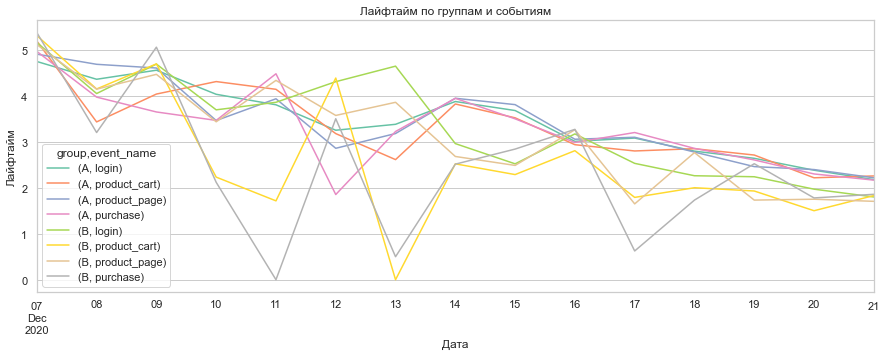

In [96]:
test_events_1.pivot_table(
    index='first_date',  
    columns=['group','event_name'], 
    values='lifetime', 
    aggfunc='mean' 
).plot(figsize=(15, 5), grid=True)
plt.title('Лайфтайм по группам и событиям')
plt.xlabel('Дата')
plt.ylabel('Лайфтайм')
plt.show()

In [97]:
test_events_1.pivot_table(
    index='first_date', 
    columns=['group','event_name'],  
    values='lifetime', 
    aggfunc='mean' 
)

group              A                                             B                                    
event_name     login product_cart product_page  purchase     login product_cart product_page  purchase
first_date                                                                                            
2020-12-07  4.744235     5.188525     4.903974  4.963504  5.158537     5.307692     5.112329  5.371859
2020-12-08  4.357860     3.430556     4.683168  3.969697  4.047244     4.147059     4.142857  3.200000
2020-12-09  4.554717     4.036145     4.602649  3.647059  4.688000     4.692308     4.464789  5.055556
2020-12-10  4.031250     4.307692     3.460526  3.463415  3.693182     2.230769     3.433333  2.117647
2020-12-11  3.802974     4.139535     3.933824  4.477273  3.857143     1.714286     4.333333  0.000000
2020-12-12  3.250000     3.176471     2.857143  1.851852  4.305195     4.384615     3.571429  3.500000
2020-12-13  3.378571     2.611111     3.178082  3.222222  4.642857     0.000000     3.857143  0.500000
2020-12-14  3.874131     3.820513     3.944836  3.943627  2.959064     2.519231     2.679487  2.512195
2020-12-15  3.678092     3.519531     3.806452  3.497738  2.519481     2.285714     2.484848  2.840000
2020-12-16  3.007921     2.935484     3.053731  2.983784  3.170000     2.805085     3.260204  3.268817
2020-12-17  3.079687     2.798995     3.096998  3.200000  2.529412     1.789474     1.648649  0.625000
2020-12-18  2.794985     2.848606     2.774793  2.855204  2.260504     2.000000     2.763636  1.730769
2020-12-19  2.639344     2.710526     2.458937  2.604348  2.238532     1.928571     1.730769  2.521739
2020-12-20  2.380759     2.216080     2.395010  2.299242  1.968354     1.500000     1.750000  1.777778
2020-12-21  2.175606     2.256098     2.215584  2.165354  1.798942     1.829268     1.704082  1.857143

Lifetime от момента регистрации до события login в группе А 07.12.2020 4.7, далее событие происходит быстрее, и 12.12.2020 составляет 3.2, с 13.12.2020 время до события снова растет и с 13.12.2020 по 17.12.2020 колеблется на уровне 3.0-3.8 со снижением с концу 2-й недели до 2.3. Для группы В в 1-й день теста время от мемента регистрации до события составил 5.4, далее событие происходит быстрее и и снижается до 2.6. 16.12.2020 - рост до 3.1 и далее снижение до конца 2-й недели.

Для события product_page lifetime от момента регистрации до перехода в просмотр карточек для группы А на 07.12.2020 -4.9. Колебания в течении 14-дневного периода колеблется между значениями 2.4 - 4.8, со снижением 12.12.2020 и в период 18.12.2020-20.12.2020. В группе В наибольшее значение зафиксоровано в 1-й день запуска теста 07.12.2020 - 5.2, к концу 2-й недели снижается до 1.8.

Для события product_cart lifetime от момента регистрации до перехода к просмотру корзины для группы А 07.12.2020 составляет 5.1, далее снижается и к концу 2-й недели составляет 2.2. Для группы В  07.12.2020 составляет 5.4, 1-ю неделю значительно колеблется, а 13.12.2020 составляет 0, хотя на эту дату lifetime для события purchase - покупки составляет 0.4, видимо, часть пользователей приходят в покупки напрямую не проходя все шаги по воронке. 2-ю неделю значение в группе В колеблется между 2.8 и 1.8, достигнув значения 1.5 20.12.2020.

Для события purchase lifetime от момента регистрации до перехода к событию покупки для группы А  наибольшее значение 07.12.2020 - 5.1, далее значения снижаются и колеблются между 4.5 и 2.3, к концу 2-й недели значения снижаются, минимальное значение - 12.12.2020 - 1.8. В группе В максимальное значение в 1-й день начала теста 07.12.2020 - 5.4, далее значения сильно колеблются весь период проведения теста, к окончанию 2-й недели значения снижаются, минимальные - 11.12.2020 и 13.12.2020.

Не очень понятная история с моментами перехода по продуктовой воронке, значения колеблются в обоих группах, создается впечатления, что часть пользователей пропускают событие product_cart - просмотр корзины и переходят сразу к покупкам. 

Рассмотрим средние значения lifetime по группам.

In [98]:
test_events_1.sort_values(by='lifetime',ascending=False)
test_events_1.pivot_table(
    index='event_name', 
    columns=['group'],  
    values='lifetime', 
    aggfunc='mean',  
)

group,A,B
event_name,,
login,3.243107,3.624848
product_cart,3.182494,3.410413
product_page,3.250048,3.589299
purchase,3.136041,3.566667


По средним значениям по группам тестирования складывается впечатление, что часть участников теста, как в группе А, так и в группе В переходили к событию покупки из продуктовой корзины, пропуская события login и product_page, возможно, была какая-то акционная ссылка на переход в корзину.

In [99]:
event_filter_=test_events_1[(test_events_1.lifetime>0) & (test_events_1.lifetime<=14)]

In [100]:
event_filter_.sort_values(by='lifetime',ascending=False)
event_filter_.pivot_table(
    index='event_name', 
    columns=['group'],  
    values='lifetime', 
    aggfunc='mean',  
)

group,A,B
event_name,,
login,4.409125,4.530997
product_cart,4.416459,4.466321
product_page,4.429692,4.528351
purchase,4.385860,4.494709


#### Выводы:

Название теста recommender_system_test. В фатафрейме данные двух тестов recommender_system_test и interface_eu_test, 1602 пользователя оказались распределены в оба теста, что не соответствует техническому заданию.

Группы, участвующие в тесте - А и В, что соответствует техническому заданию.

Дата запуска: 2020-12-07 - соответствует техническому заданию.

Дата остановки набора новых пользователей: 2020-12-21 - при проверке последняя дата регистрации  новых пользователей в recommender_system_test- 2020-12-21 - что соответствует техническому заданию. 

Дата остановки: 2021-01-04. При проверке последние данные по событиям приходятся на 2020-12-30. Данные до 2021-01-04 отсутствуют.

Ожидаемое количество участников теста: 15% новых пользователей из региона EU. Количество новых пользователей - участников теста 15%.

Используем калькулятор Sample Size Calculator (Evan's Awesome A/B Tools) чтобы оценить достаточно ли в каждой группе пользователей для того, чтобы тест показал статистически значимый  результат. Статистически значимый результат - это результат, который в контексте эксперимента считается достоверным. Слишком широкая выборка требует больше ресурсов для проведения теста, чем необходимо. Недостаточно широкая выборка не покажет статистически значимого результата.

Baseline conversion rate - это заданный условиями проекта базовый показатель конверсии в 50%, исходя из которого необходимо оценить возможность получения достоверных результатов А/В-теста.

В ячейке Minimum Detectable Effect указываем какой минимальный результат от А/В-теста ожидаем получить. По условию задания ожидаемый эффект -пользователи должны показать улучшение каждой метрики не менее, чем на 5 процентных пунктов. Вводим ожидаемый результат, который мы хотим получить - 5%. Под шкалой Minimum Detectable Effect при введении ожидаемого результата в 5%, показывает диапазон 45-55%. В нашем случае мы имеем цель повысить конверсию, результат эксперимента должен быть больше или равен 55%. Калькулятор рассчитал размер выборки - 1567.

Можно настроить значения статистической силы и уровень значимости, они влияют на размер выборки. По умолчанию в калькуляторе стоят значения 80% и 5% - в основном их уже достаточно для того, чтобы получить размер выборки, который даст статистически значимый результат.

In [101]:
count_test=test_events_1.groupby('group').agg({'user_id':'nunique'})
perc_A=round(test_events_1.query('group=="A"')['user_id'].nunique()/test_events_1['user_id'].nunique()*100,2)
perc_B=round(test_events_1.query('group=="B"')['user_id'].nunique()/test_events_1['user_id'].nunique()*100,2)
count_test['%']=[perc_A,perc_B]
count_test

,user_id,%
group,,
A,2604,74.81
B,877,25.19


Необходимый размер выборки 1567 для каждой группы А/В-теста, который даст статистически значимый результат, исходя из базового показателя конверсии в 50% не достигнут. Группа В (877) не достигает необходимого размера выборки. 

#### Исследовательский анализ данных.

Рассмотрим динамику набора пользователей в группы теста.

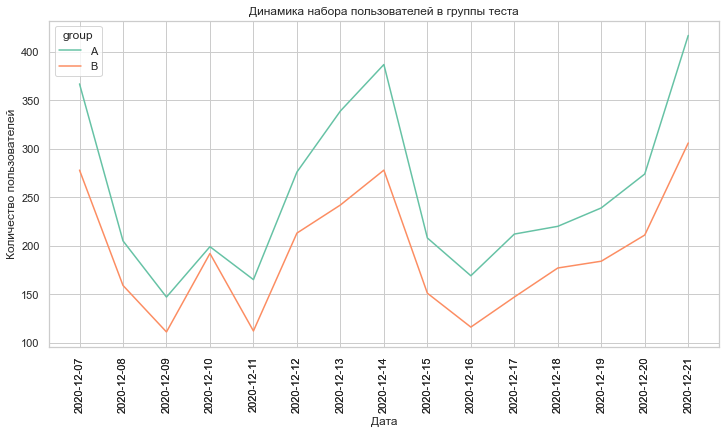

In [102]:
test_recommender_1=test_recommender_.groupby(['first_date','group'])['user_id'].count().reset_index()

plt.figure(figsize=(12,6))
sns.set_style("whitegrid")
ax=sns.lineplot(data=test_recommender_1,x='first_date',y='user_id',hue='group')
ax.set_xticks(test_recommender_1['first_date'])
plt.xticks(rotation=90)
ax.set_title('Динамика набора пользователей в группы теста')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.show()

В среднем динамика регистрации пользователей в группы теста аналогичны, учитывая что группы А и В отличаются по количеству. Пик регистрации приходится на 1-й и 8-й день теста и в группе А, и в группе В. Снижение количества регистраций приходится на 09.12.2020,11.12.2020 и 16.12.2020, далее обе группы показывают рост регистрации пользователей в группы теста.

Рассмотрим количество событий в группах теста по датам.

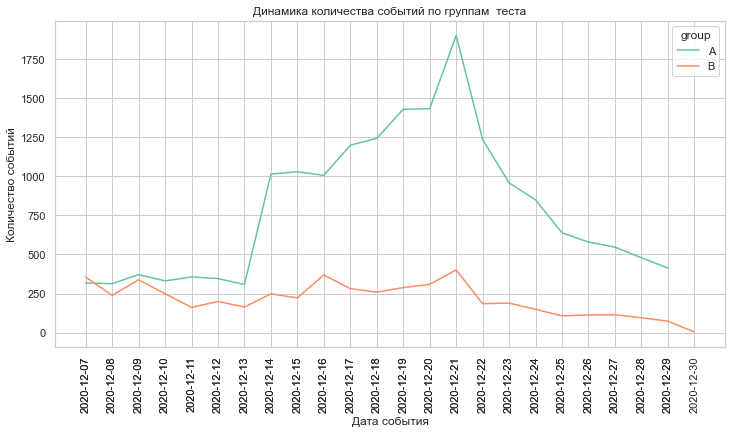

In [103]:
test_recommender_2=test_events_.groupby(['event_dt_','group'])['event_name'].count().reset_index()

plt.figure(figsize=(12,6))
sns.set_style("whitegrid")
ax=sns.lineplot(data=test_recommender_2,x='event_dt_',y='event_name',hue='group')
ax.set_xticks(test_recommender_2['event_dt_'])
plt.xticks(rotation=90)
ax.set_title('Динамика количества событий по группам  теста')
plt.xlabel('Дата события')
plt.ylabel('Количество событий')
plt.show()

Группа В практически стабильна. С 07.12.2020 по 10.12.2020 и с 14.12.2020 по 21.12.2021 количество событий находится в диапазоне между 200 и 400, ниже 200 событий происходит после 10.12.2020 по 13.12.2020 и 21.12.2020, после чего неуклонно уменьшается и 30.12.2020 приходят к нулю.
В группе А с 07.12.2020 по 13.12.2020 фиксируется количество событий на уровне приблизительно 250, далее резкий рост, пик приходится на период 19-20.12.2023, после чего идет снижение и данные обрываются на дате 29.12.2020.

Рассмотрим количество событий, приходящегося на каждого пользователя.

In [104]:
user_group=test_events_.groupby(['user_id','group']).agg({'event_name':'count'}).sort_values(by='event_name',ascending=False)
user_group

,,event_name
user_id,group,
1198061F6AF34B7B,B,28
115EBC1CA027854A,B,27
CED71698585A2E46,A,24
1BFEE479308EFF44,A,24
6E3DF9C69A6B607E,A,21
...,...,...
4400B2091A6E2CCD,A,1
921FFC6F0F506A82,A,1
92701F9DF59DC422,B,1


Наибольшее количество событий -28 и 27 у 1 пользователя, 24 - у двух пользователей. Наименьшее количество событий -2. Участники теста, совершившие как наибольшее, так и наименьшее количество событий, есть и в группе А и в группе В.

In [105]:
user_group_3=test_events_.groupby(['group']).agg({'event_name':'count'}).sort_values(by='event_name',ascending=False)
user_group_3

,event_name
group,
A,18309
B,5111


Участники теста из группы А совершили 18309 событий, группы В -5111.

In [106]:
user_group_1=test_events_.groupby(['group']).agg({'user_id':'nunique','event_name':'count'}).sort_values(by='user_id',ascending=False)
perc_A=round(test_events_.query('group=="A"')['event_name'].count()/test_events_['event_name'].count()*100,2)
perc_B=round(test_events_.query('group=="B"')['event_name'].count()/test_events_['event_name'].count()*100,2)
user_group_1['% of total events']=[perc_A,perc_B]
perc_A_=round(test_events_.query('group=="A"')['user_id'].nunique()/test_events_.query('group=="A"')['event_name'].count()*100,2)
perc_B_=round(test_events_.query('group=="B"')['user_id'].nunique()/test_events_.query('group=="B"')['event_name'].count()*100,2)
user_group_1['% of user events']=[perc_A_,perc_B_]
event_A=test_events_.query('group=="A"')['event_name'].count()
event_B=test_events_.query('group=="B"')['event_name'].count()
user_A=test_events_.query('group=="A"')['user_id'].nunique()
user_B=test_events_.query('group=="B"')['user_id'].nunique()
user_eventA=round(event_A/user_A,2)
user_eventB=round(event_B/user_B,2)
user_group_1['mean_event_of_user']=[user_eventA,user_eventB]
user_group_1

,user_id,event_name,% of total events,% of user events,mean_event_of_user
group,,,,,
A,2604,18309,78.18,14.22,7.03
B,877,5111,21.82,17.16,5.83


В группе тестирования А принимают участие 2604 уникальных пользователей, которые совершили 18309 событий, что состаляет 78.18% от числа всех событий и 14.22% отношение числа пользователей к количеству совершенных ими событий.

В группе B принимает участие 877 уникальных пользователей, которые совершили 5111 событий, 21.82% от общего числа совершенных событий и 17.16% отношение числа участников теста к количеству совершенных событий.

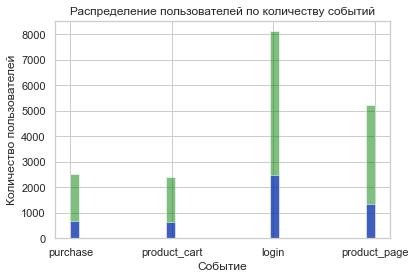

In [107]:
test_events_[test_events_['group'] =='A']['event_name'].hist(bins=35, alpha=0.5, color='green')
test_events_[test_events_['group'] =='B']['event_name'].hist(bins=35, alpha=0.5, color='blue')
plt.title('Распределение пользователей по количеству событий')
plt.xlabel('Событие')
plt.ylabel('Количество пользователей')
plt.show();

In [108]:
user_group_2=test_events_.groupby(['event_name','group']).agg({'user_id':'count'}).sort_values(by='group').reset_index()
user_group_2

,event_name,group,user_id
0,login,A,8124
1,product_cart,A,2422
2,product_page,A,5227
3,purchase,A,2536
4,login,B,2471
5,product_cart,B,653
6,product_page,B,1327
7,purchase,B,660


Количество событий, которые совершают пользователи группы А распределились следующим образом: в группе А login -8124, product_page - 5227, product_cart - 2422, purchase - 2536; в группе В login -2471, product_page - 1327, product_cart - 653, purchase - 660.

In [109]:
user_group_5=test_events_.groupby(['event_name','group']).agg({'user_id':'nunique'}).sort_values(by='group').reset_index()
user_group_5

,event_name,group,user_id
0,login,A,2604
1,product_cart,A,782
2,product_page,A,1685
3,purchase,A,833
4,login,B,877
5,product_cart,B,244
6,product_page,B,493
7,purchase,B,249


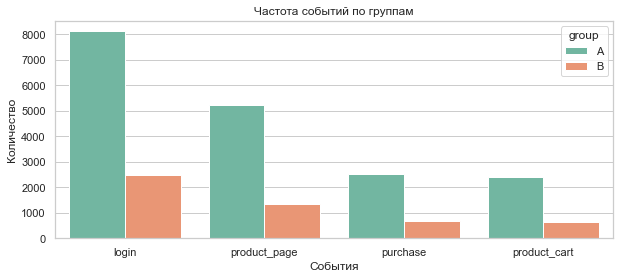

In [110]:
user_group_2=test_events_.groupby(['event_name','group']).agg({'user_id':'count'}).sort_values(by='user_id',ascending=False).reset_index()
plt.figure(figsize=(10,4))
sns.barplot(data=user_group_2,x='event_name',y='user_id', hue='group')
plt.title('Частота событий по группам')
plt.xlabel('События')
plt.ylabel('Количество')
plt.show()


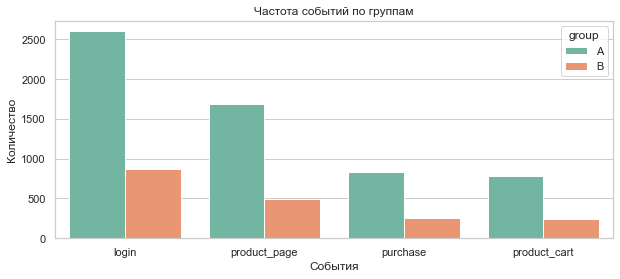

In [111]:
user_group_2_=test_events_.groupby(['event_name','group']).agg({'user_id':'nunique'}).sort_values(by='user_id',ascending=False).reset_index()
plt.figure(figsize=(10,4))
sns.barplot(data=user_group_2_,x='event_name',y='user_id', hue='group')
plt.title('Частота событий по группам')
plt.xlabel('События')
plt.ylabel('Количество')
plt.show()


In [112]:
test_events_10=test_events_.copy()

In [113]:
test_events_10['event_count']=test_events_10.groupby('user_id')['event_name'].transform('count')

In [114]:
test_events_10=test_events_10[['user_id','group','event_name','event_count']]

In [115]:
test_events_10['event_mean']=test_events_10.groupby(['user_id','event_name','group'])['event_count'].transform('mean')

In [116]:
test_events_11=test_events_10.drop_duplicates()

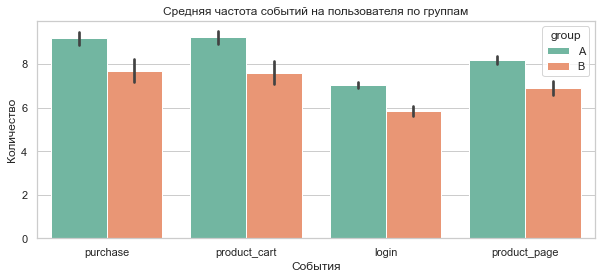

In [117]:
plt.figure(figsize=(10,4))
sns.barplot(data=test_events_11,x='event_name',y='event_mean', hue='group')
plt.title('Средняя частота событий на пользователя по группам')
plt.xlabel('События')
plt.ylabel('Количество')
plt.show()


In [118]:
test_events_11['event_mean'].mean()

7.6320329599588

In [119]:
ev_A=test_events_11[test_events_11['group'] =='A']['event_mean'].mean()
ev_A

7.959349593495935

In [120]:
ev_B=test_events_11[test_events_11['group'] =='B']['event_mean'].mean()
ev_B

6.594739667203435

In [121]:
round(ev_B/ev_A,2)

0.83

In [122]:
user_group_3=test_events_11.groupby(['event_name','group']).agg({'event_mean':'mean'}).sort_values(by='group').reset_index()
user_group_3

,event_name,group,event_mean
0,login,A,7.031106
1,product_cart,A,9.232737
2,product_page,A,8.193472
3,purchase,A,9.192077
4,login,B,5.827822
5,product_cart,B,7.598361
6,product_page,B,6.910751
7,purchase,B,7.686747


Среднее количество событий, совершенных одним пользователем 7,6. В группе В пользователи совершают в среднем 8 событий, в группе В - 6,5. Пользователи в группе В в среднем cовершают на 17% меньше событий, чем в группе А.

In [123]:
s_A=test_events_[test_events_['group']=="A"].reset_index()
s_A['event_count_A']=s_A.groupby('user_id')['event_dt_'].transform('count')
s_A=s_A[['user_id','event_count_A']]
s_A_1=s_A.drop_duplicates()

In [124]:
s_B=test_events_[test_events_['group']=="B"].reset_index()
s_B['event_count_B']=s_B.groupby('user_id')['event_dt_'].transform('count')
s_B=s_B[['user_id','event_count_B']]
s_B_1=s_B.drop_duplicates()


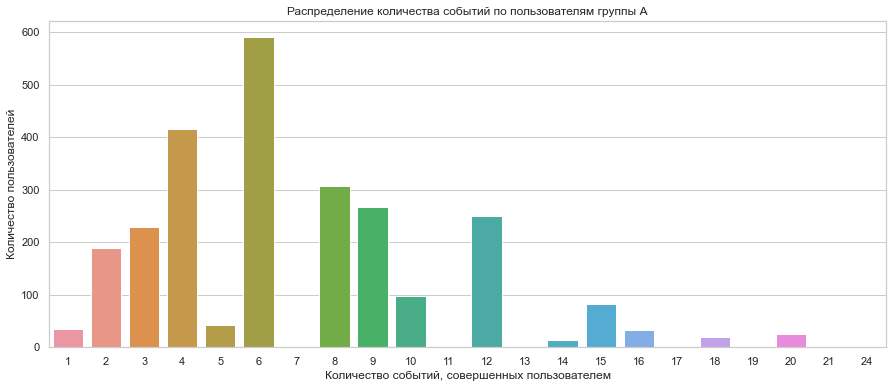

In [125]:
plt.figure(figsize=(15,6))
sns.countplot(x='event_count_A',data=s_A_1)
plt.title('Распределение количества событий по пользователям группы А')
plt.xlabel('Количество событий, совершенных пользователем')
plt.ylabel('Количество пользователей')
plt.show()

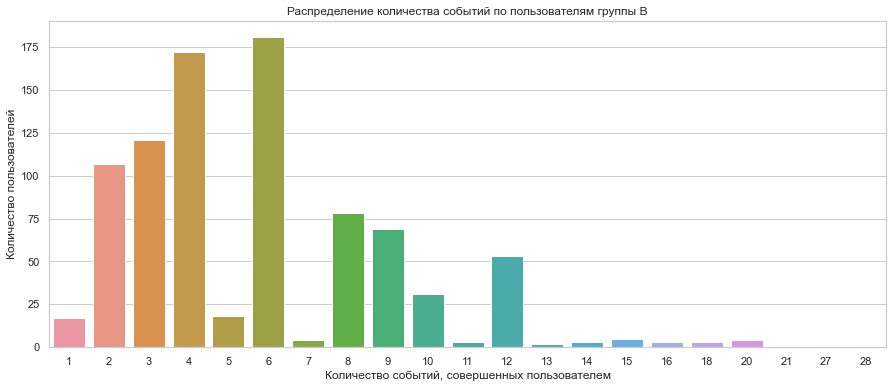

In [126]:
plt.figure(figsize=(15,6))
sns.countplot(x='event_count_B',data=s_B_1)
plt.title('Распределение количества событий по пользователям группы B')
plt.xlabel('Количество событий, совершенных пользователем')
plt.ylabel('Количество пользователей')
plt.show()

In [127]:
s_A_B=test_events_10.copy()

In [128]:
s_A_B_1=s_A_B.drop_duplicates()

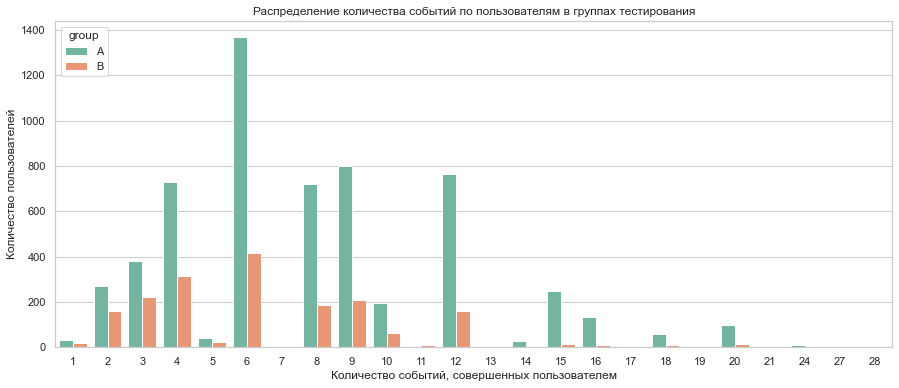

In [129]:
plt.figure(figsize=(15,6))
ax=sns.countplot(x='event_count',hue='group',data=s_A_B_1)
plt.title('Распределение количества событий по пользователям в группах тестирования')
plt.xlabel('Количество событий, совершенных пользователем')
plt.ylabel('Количество пользователей')
plt.show()

 Наибольшее количество событий, которые совершает пользователь в группе А -6, в группе В - также 6. В группе А большое количество пользователей совершили 9,12,4 и 8 событий. В группе В большое количество пользователей совершили 4,3,9 и 8 событий. В корзинах количества событий, совершенных пользователем, по количеству пользователей, совершавших эти события, опережает группа А, что логично, так как она более многочисленна.

Рассмотрим не совпадает ли время проведения теста с другими маркетинговыми событиями.

In [130]:
max_date='2021-04-01'

In [131]:
min_date='2020-12-07'

In [132]:
marketing_events=marketing_events.query('finish_dt>=@min_date & start_dt<=@max_date')
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


На время проведения нашего теста выпадает проведение Рождественских и Новогодних маркетинговых мероприятий. Новогодняя рекламная кампания не затрагивает регион EU, поэтому оказать влияние на результаты проводимого теста не может. Рождественская рекламная кампания проходит в том числе и в регионе EU, поэтому теоретически может оказать влияние на результаты проводимого теста. В то же время, мы рассматриваем ожидаемый эффект в течение 14 дней с момента регистрации, то есть до 22.12.2020. Рождественская рекламная кампания проводится с 25.12.2020 и наши периоды не пересекаются.

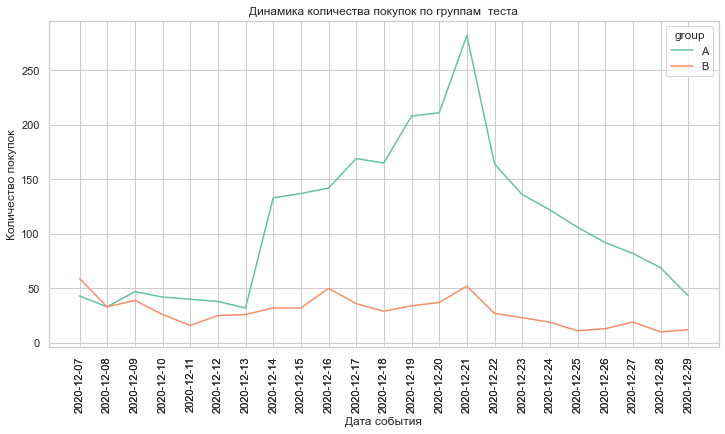

In [133]:
test_recommender_3=test_events_.query('event_name=="purchase"')
test_recommender_4=test_recommender_3.groupby(['event_dt_','group'])['event_name'].count().reset_index()

plt.figure(figsize=(12,6))
sns.set_style("whitegrid")
ax=sns.lineplot(data=test_recommender_4,x='event_dt_',y='event_name',hue='group')
ax.set_xticks(test_recommender_4['event_dt_'])
plt.xticks(rotation=90)
ax.set_title('Динамика количества покупок по группам  теста')
plt.xlabel('Дата события')
plt.ylabel('Количество покупок')
plt.show()

Рождественская рекламная кампания стартует 25.12.2020. Количество покупок у участников теста в группе А резко снижается в период начала проведения Рождественской рекламной кампании с 25.12.2020, а в группе В держится на стабильно низком уровне. Предположение о том, что участники теста стали более активно делать покупки в рамках тестируемого продукта в период проведения рекламной кампании, не подтвердилось. Наоборот, продажи в этот период снизились, хотя в праздничный период, когда люди массово покупают и дарят подарки, можно было ожидать роста продаж.
В то же время, можно предположить, что снижение покупательской активности в рамках теста может быть связано с запуском Рождественской рекламной кампании, так как участники теста могли счесть предлагаемые товары и Рождественские скидки в рамках Рождественской рекламной кампании более привлекательными, чем условия, предлагаемые участникам проводимого теста. 

Проверим время проведения конкурирующего теста interface_eu_test, не совпадает ли оно с временем проведения исследуемого теста recommender_system_test.

In [134]:
test_users.groupby('ab_test').agg({'first_date':['min','max'],'group':['first','last']})

first_date            group     
                               min        max first last
ab_test                                                 
interface_eu_test       2020-12-07 2020-12-23     A    B
recommender_system_test 2020-12-07 2020-12-21     A    B

Тесты проводятся практически в одно и то же время, что может повлиять на результаты исследования.

Посмотрим дату вхождения группы А конкурирующего теста в группу А исследуемого теста.

In [135]:
test_=test_interface.query('group=="A"')

In [136]:
test_1=test_recommender.query('group=="B"')

In [137]:
test_2 = pd.merge(test_,test_1, on = 'user_id',how='inner')

In [138]:
test_2

,user_id,first_date_x,region_x,device_x,week_x,group_x,ab_test_x,first_date_y,region_y,device_y,week_y,group_y,ab_test_y
0,DD4352CDCF8C3D57,2020-12-07,EU,Android,50,A,interface_eu_test,2020-12-07,EU,Android,50,B,recommender_system_test
1,7779596AE52635A8,2020-12-07,EU,iPhone,50,A,interface_eu_test,2020-12-07,EU,iPhone,50,B,recommender_system_test
2,6A581C74EF4D5F44,2020-12-07,EU,iPhone,50,A,interface_eu_test,2020-12-07,EU,iPhone,50,B,recommender_system_test
3,1632E8454F655D06,2020-12-07,EU,Mac,50,A,interface_eu_test,2020-12-07,EU,Mac,50,B,recommender_system_test
4,53732758D90FB1E4,2020-12-07,EU,PC,50,A,interface_eu_test,2020-12-07,EU,PC,50,B,recommender_system_test
...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,684E01AE282B9505,2020-12-20,EU,Android,51,A,interface_eu_test,2020-12-20,EU,Android,51,B,recommender_system_test
333,65A30CEC01FAB999,2020-12-20,EU,Android,51,A,interface_eu_test,2020-12-20,EU,Android,51,B,recommender_system_test
334,E4EB5A73A37A55CA,2020-12-20,EU,Android,51,A,interface_eu_test,2020-12-20,EU,Android,51,B,recommender_system_test
335,902F92052587344F,2020-12-20,EU,Mac,51,A,interface_eu_test,2020-12-20,EU,Mac,51,B,recommender_system_test


In [139]:
test_2_=test_2.sort_values('first_date_x')

In [140]:
test_2_.groupby('group_y').agg({'first_date_y':['min','max']})

first_date_y           
                 min        max
group_y                        
B         2020-12-07 2020-12-21

In [141]:
test_2.groupby('group_x').agg({'first_date_x':['min','max']})

first_date_x           
                 min        max
group_x                        
A         2020-12-07 2020-12-21

Дата регистрации новых участников группы В проводимого теста и группы А конкурирующего теста - 07.12.2020. То, что тесты проводятся одновременно, может оказать влияние на результаты проводимого теста.

Ранее были выявлены 1602 пользователя, которые участвовали в обоих конкурирующих тестах одновременно. Если не принимать во внимание данное пересечение, можно предположить, что оба теста проводятся независимо друг от друга. Но в то же время если бы оба конкурирующих теста не проводилось в одно и то же время, то количество участников в группах проводимого теста могло быть другим. Сейчас мы видим, что часть пользователей участвуют в исследуемом нами тесте, часть в конкурирующем тесте, а часть в обоих тестах одновременно. Если бы в этот период проводился только один тест, то количество участников теста могло бы быть больше, и группы более наполнены и распределение по группам могло бы быть другим.
На мой взгляд проведение конкурирующего теста или рекламной кампании в период проведения А/В-теста, может оказать негативное влияние на количество участников теста, совершаемых ими покупок и, соответственно, на результаты проводимого теста.

##### Продуктовая воронка.

In [142]:
total_data_=pd.DataFrame()
total_data_=event_filter_.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()
total_users=event_filter_['user_id'].nunique()
total_data_['perc'] = round((total_data_['user_id']/total_users*100),2)
total_data_['perc_'] =round((total_data_['user_id']/(total_data_['user_id'].shift(+1))*100),2)
total_data_

,event_name,user_id,perc,perc_
0,login,3127,100.00,NaN
1,product_page,1940,62.04,62.04
2,purchase,958,30.64,49.38
3,product_cart,917,29.33,95.72


По количеству событий пользователи, участвующие в тесте, распределились следующим образом при переходе по продуктовой воронке: событие login -3157 пользователей, к событию product_page перешли 1961 или 62.12% участников теста, к событию product_cart перешли 923 или 29.24% пользователей, а непосредственно к покупке 968 или 30.66%. Причем покупки совершили большее количество пользователей, чем перешли к просмотру продуктовой корзины (product_cart). На предыдущием этапе этот момент тоже обращал на сетя внимание - возможно, некоторые пользователи переходят по каким-то акционным ссылкам и совершают покупки, пропуская какие-то шаги в продуктовой воронке.

In [143]:
new_index={2:3,3:2}

In [144]:
total_data_1=pd.DataFrame()
total_data_1=total_data_.rename(new_index).sort_index()
total_users=event_filter_['user_id'].nunique()
total_data_1['perc'] = round((total_data_1['user_id']/total_users*100),2)
total_data_1['perc_'] =round((total_data_1['user_id']/(total_data_1['user_id'].shift(+1))*100),2)
total_data_1

,event_name,user_id,perc,perc_
0,login,3127,100.00,NaN
1,product_page,1940,62.04,62.04
2,product_cart,917,29.33,47.27
3,purchase,958,30.64,104.47


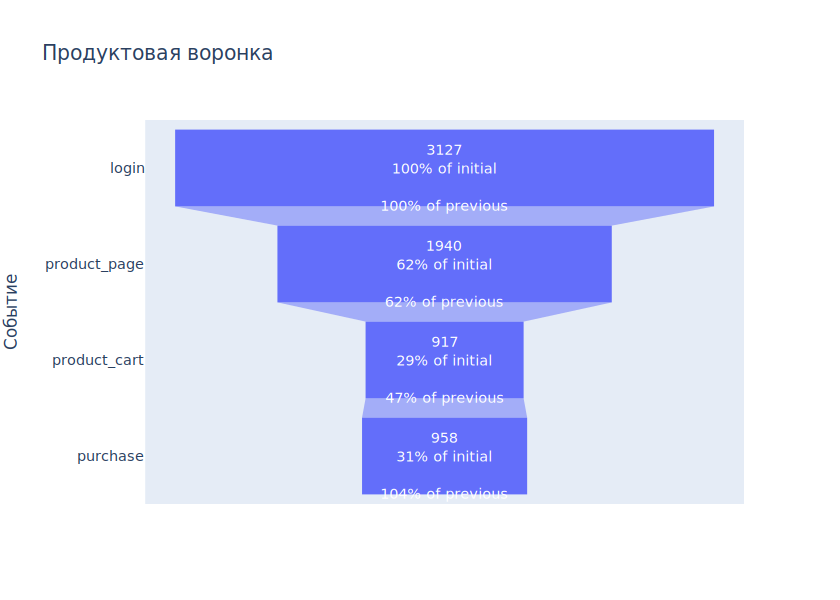

In [145]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'All groups',
    y = total_data_1['event_name'],
    x = total_data_1['user_id'],
    textinfo = "value+percent initial+percent previous"))
fig.update_layout(title = "Продуктовая воронка")
fig.update_yaxes(title_text="Событие")
fig.show("svg")

На графике хорошо видно, что последовательность перехода по продуктовой воронке нарушена при переходе от просмотра корзины к покупкам. Очевидно, что часть пользователей, совершая покупки, пропускают этот шаг.

Рассмотрим прохождение продуктовой воронки каждой группы теста.

In [146]:
group_A=pd.DataFrame()
group_A=event_filter_.query('group == "A"').groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()
group_users=event_filter_['user_id'].nunique()
group_A['perc']=round((group_A['user_id']/group_users*100),2)
group_A['perc_']=round((group_A['user_id']/(group_A['user_id'].shift(+1))*100),2)

In [147]:
group_B=pd.DataFrame()
group_B=event_filter_.query('group == "B"').groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()
group_users=event_filter_['user_id'].nunique()
group_B['perc']=round((group_B['user_id']/group_users*100),2)
group_B['perc_']=round((group_B['user_id']/(group_B['user_id'].shift(+1))*100),2)

In [148]:
group_B

,event_name,user_id,perc,perc_
0,login,736,23.54,NaN
1,product_page,401,12.82,54.48
2,product_cart,198,6.33,49.38
3,purchase,197,6.30,99.49


In [149]:
new_index={2:3,3:2}
group_A_=pd.DataFrame()
group_A_=group_A.rename(new_index).sort_index()
group_usersA=event_filter_['user_id'].nunique()
group_A_['perc']=round((group_A_['user_id']/group_usersA*100),2)
group_A_['perc_']=round((group_A_['user_id']/(group_A_['user_id'].shift(+1))*100),2)

In [150]:
group_A_

,event_name,user_id,perc,perc_
0,login,2391,76.46,NaN
1,product_page,1539,49.22,64.37
2,product_cart,719,22.99,46.72
3,purchase,761,24.34,105.84


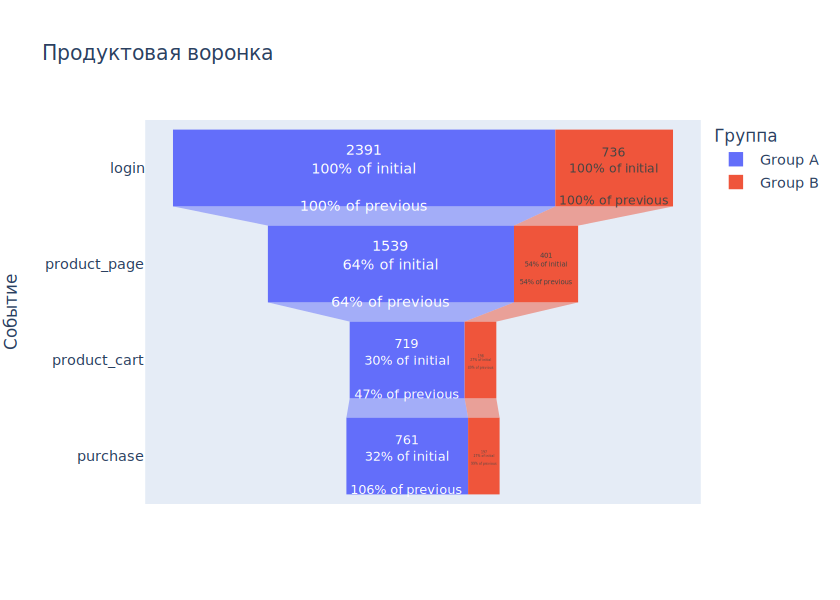

In [151]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Group A',
    y = group_A_['event_name'],
    x = group_A_['user_id'],
    textinfo = "value+percent initial+percent previous"))

fig.add_trace(go.Funnel(
    name = 'Group B',
    orientation = "h",
    y = group_B['event_name'],
    x = group_B['user_id'],
    textposition = "inside",
    textinfo = "value+percent initial+percent previous"))
fig.update_layout(title = "Продуктовая воронка")
fig.update_layout(legend_title_text = "Группа")
fig.update_yaxes(title_text="Событие")
fig.show("svg")

В группе А и в группе В наблюдается та же картина - покупки совершили большее количество пользователей, чем число пользователей, совершивших просмотр корзины, хотя при переходе пользователей по продуктовой воронке должна соблюдаться другая последовательность. Укрепляемся в предположении, что имеется доплнительная ссылка, позволяющая части пользователей переходить непосредственно к покупкам, минуя шаг продуктовой воронки, либо какой-то технический сбой. На мой взгляд это может отразиться на чистоте результатов проводимого тестирования.

In [152]:
user_login_A=event_filter_.query('event_name=="login" and group=="A"').nunique()
user_product_page_A=event_filter_.query('event_name=="product_page" and group=="A"').nunique()
user_product_cart_A=event_filter_.query('event_name=="product_cart" and group=="A"').nunique()
user_purchase_A=event_filter_.query('event_name=="purchase" and group=="A"').nunique()
user_login_B=event_filter_.query('event_name=="login" and group=="B"').nunique()
user_product_page_B=event_filter_.query('event_name=="product_page" and group=="B"').nunique()
user_product_cart_B=event_filter_.query('event_name=="product_cart" and group=="B"').nunique()
user_purchase_B=event_filter_.query('event_name=="purchase" and group=="B"').nunique()
login_A=user_login_A['user_id'].sum()
product_page_A=user_product_page_A['user_id'].sum()
product_cart_A=user_product_cart_A['user_id'].sum()
purchase_A=user_purchase_A['user_id'].sum()
login_B=user_login_B['user_id'].sum()
product_page_B=user_product_page_B['user_id'].sum()
product_cart_B=user_product_cart_B['user_id'].sum()
purchase_B=user_purchase_B['user_id'].sum()

In [153]:
l_1=['login','product_page','product_cart','purchase']
l_2=[login_A,product_page_A,product_cart_A,purchase_A]
l_3=[login_B,product_page_B,product_cart_B,purchase_B]
conv=pd.DataFrame()
conv['group_A']=l_2
conv['group_B']=l_3
conv['perc_B']=round(conv['group_B']/event_filter_.query('group=="B"')['user_id'].nunique()*100,2)
conv['perc_A']=round(conv['group_A']/event_filter_.query('group=="A"')['user_id'].nunique()*100,2)
conv['perc_prev_B']=round((conv['group_B']/(conv['group_B'].shift(+1))*100),2)
conv['perc_prev_A']=round((conv['group_A']/(conv['group_A'].shift(+1))*100),2)
conv.index=l_1
conv

,group_A,group_B,perc_B,perc_A,perc_prev_B,perc_prev_A
login,2391,736,100.00,100.00,NaN,NaN
product_page,1539,401,54.48,64.37,54.48,64.37
product_cart,719,198,26.90,30.07,49.38,46.72
purchase,761,197,26.77,31.83,99.49,105.84


Ожидаемый эффект увеличения конверсии в группе В относительно конверсии в группе А на 10 процентных пунктов не наблюдается.

Создаем массив уникальных пар значений дат и групп datesGroups. Получаем агрегированные кумулятивные по дням данные о покупках ordersAggregated и о пользователях visitorsAggregated. Объединяем кумулятивные данные и строим график выручки группы А и группы В.

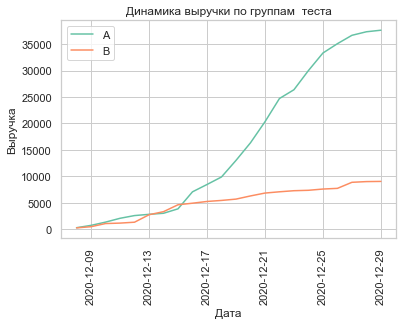

In [154]:
datesGroups = event_filter_[['event_dt_', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: event_filter_[
        np.logical_and(
            event_filter_['event_dt_'] <= x['event_dt_'], event_filter_['group'] == x['group']
        )
    ].agg(
        {
            'event_dt_': 'max',
            'group': 'max',
            'details': 'count',
            'details': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['event_dt_', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: event_filter_[
        np.logical_and(
            event_filter_['event_dt_'] <= x['event_dt_'], event_filter_['group'] == x['group']
        )
    ].agg({'event_dt_': 'max', 'group': 'max', 'details': 'count'}),
    axis=1,
).sort_values(by=['event_dt_', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['event_dt_', 'group'], right_on=['event_dt_', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'revenue',
    'number_of_purchases',
]

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date', 'revenue', 'number_of_purchases']]

cumulativeRevenueB =cumulativeData[cumulativeData['group']=='B'][['date', 'revenue', 'number_of_purchases']]

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.xticks(rotation=90)
plt.title('Динамика выручки по группам  теста')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend();

Выручка группы А с 13.12.2023 значительно опережает выручку от покупок группы В. Возможно, это свидетельствует о росте числа покупок, либо о совершении очень дорогих покупок в группе А.

Строим график средней стоимости покупки по группам тестирования.

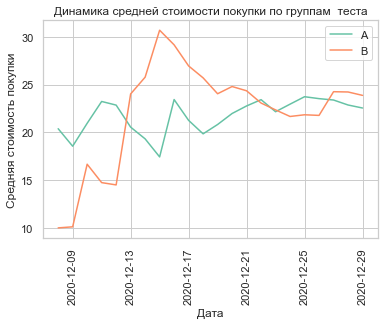

In [155]:
plt.plot(cumulativeRevenueA['date'],cumulativeRevenueA['revenue']/cumulativeRevenueA['number_of_purchases'],label='A')
plt.plot(cumulativeRevenueB['date'],cumulativeRevenueB['revenue']/cumulativeRevenueB['number_of_purchases'],label='B')
plt.xticks(rotation=90)
plt.title('Динамика средней стоимости покупки по группам  теста')
plt.xlabel('Дата')
plt.ylabel('Средняя стоимость покупки')
plt.legend();

Средняя стоимость покупки становится более равномерной с 21.12.2023, практически к концу рассматриваемого периода.

In [156]:
mergedCumulativeRevenue=cumulativeRevenueA.merge(cumulativeRevenueB,left_on='date',right_on='date',how='left',suffixes=['A','B'])

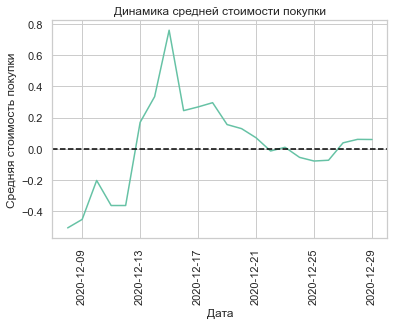

In [157]:
plt.plot(mergedCumulativeRevenue['date'],(mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['number_of_purchasesB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['number_of_purchasesA'])-1)
plt.axhline(y=0,color='black',linestyle='--')
plt.title('Динамика средней стоимости покупки')
plt.xlabel('Дата')
plt.ylabel('Средняя стоимость покупки')
plt.xticks(rotation=90);

В период с 13.12.2020 до 18.12.2020 скорее всего были крупные заказы.

Считаем конверсию.

In [158]:
purchase_=event_filter_.query('event_name=="purchase"')

In [159]:
datesGroups = purchase_[['event_dt_', 'group']].drop_duplicates()
purchase_agg = datesGroups.apply(
    lambda x: purchase_[
        np.logical_and(
            purchase_['event_dt_'] <= x['event_dt_'], purchase_['group'] == x['group']
        )
    ].agg(
        {
            'event_dt_': 'max',
            'group': 'max',
            'user_id': 'nunique',
        }
    ),
    axis=1,
).sort_values(by=['event_dt_', 'group'])

buyers_agg= datesGroups.apply(
    lambda x: event_filter_[
        np.logical_and(
            event_filter_['event_dt_'] <= x['event_dt_'], event_filter_['group'] == x['group']
        )
    ].agg({'event_dt_': 'max', 'group': 'max', 'user_id':'nunique'}),
    axis=1,
).sort_values(by=['event_dt_', 'group'])

cumulativeData_ = purchase_agg.merge(
    buyers_agg, on=['event_dt_', 'group']
)
cumulativeData_.columns = [
    'date',
    'group',
    'buyers',
    'visitors',
]

cumulativeData_['conversion']=cumulativeData_['buyers']/cumulativeData_['visitors']

In [160]:
cumulativeData_

,date,group,buyers,visitors,conversion
0,2020-12-08,A,13,57,0.228070
1,2020-12-08,B,23,72,0.319444
2,2020-12-09,A,33,132,0.250000
3,2020-12-09,B,40,130,0.307692
4,2020-12-10,A,53,196,0.270408
5,2020-12-10,B,52,190,0.273684
6,2020-12-11,A,66,252,0.261905
7,2020-12-11,B,58,220,0.263636
8,2020-12-12,A,82,320,0.256250
9,2020-12-12,B,66,241,0.273859


Отделяем данные по группе А и группе В и выводим график.

In [161]:
cumulativeDataA_=cumulativeData_[cumulativeData_['group']=='A']
cumulativeDataB_=cumulativeData_[cumulativeData_['group']=='B']

In [162]:
cumulativeDataA_

,date,group,buyers,visitors,conversion
0,2020-12-08,A,13,57,0.228070
2,2020-12-09,A,33,132,0.250000
4,2020-12-10,A,53,196,0.270408
6,2020-12-11,A,66,252,0.261905
8,2020-12-12,A,82,320,0.256250
10,2020-12-13,A,97,377,0.257294
12,2020-12-14,A,104,421,0.247031
14,2020-12-15,A,156,627,0.248804
16,2020-12-16,A,211,795,0.265409
18,2020-12-17,A,264,955,0.276440


In [163]:
cumulativeDataB_

,date,group,buyers,visitors,conversion
1,2020-12-08,B,23,72,0.319444
3,2020-12-09,B,40,130,0.307692
5,2020-12-10,B,52,190,0.273684
7,2020-12-11,B,58,220,0.263636
9,2020-12-12,B,66,241,0.273859
11,2020-12-13,B,74,271,0.273063
13,2020-12-14,B,80,289,0.276817
15,2020-12-15,B,92,335,0.274627
17,2020-12-16,B,99,365,0.271233
19,2020-12-17,B,116,426,0.272300


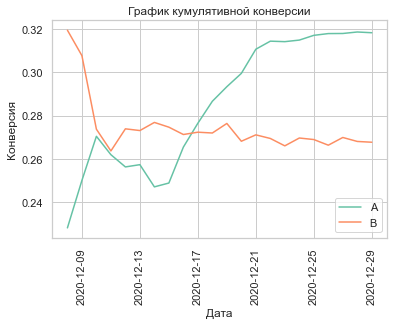

In [164]:
plt.plot(cumulativeDataA_['date'],cumulativeDataA_['conversion'],label='A')
plt.plot(cumulativeDataB_['date'],cumulativeDataB_['conversion'],label='B')
plt.title('График кумулятивной конверсии')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.xticks(rotation=90)
plt.legend();

Конверсия группы В опережает конверсию группы А в период до 17.12.2020. Далее конверсия группы А значительно опережает конверсию группы В.

Строим график относительного прироста конверсии группы В относительно группы А.

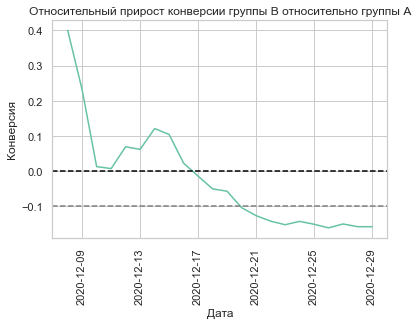

In [165]:
mergedCumulativeConversions=cumulativeDataA_[['date','conversion']].merge(cumulativeDataB_[['date','conversion']],left_on='date',right_on='date',how='left',suffixes=['A','B'])
plt.plot(mergedCumulativeConversions['date'],mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.xticks(rotation=90)
plt.title('Относительный прирост конверсии группы В относительно группы А')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.axhline(y=0,color='black',linestyle='--')
plt.axhline(y=-0.1,color='grey',linestyle='--');

Относительный прирост конверсии группы В относительно конверсии группы А наблюдается в начале теста, 11.12.2020 равна 0, до 19.12.2020 опережает. В период с 19.12.2020 конверсия группы В ниже конверсии группы А до конца проведения теста.

##### Оценка результатов А/В-тестирования.

Проверим статистическую разницу долей. Нужно сопоставить доли уникальных пользователей - проверить три гипотезы о равенстве долей в группах А и В при конверсии в просмотр карточек товаров (product_page), просмотр корзины (product_cart), покупке (purchase). Проверку проведем с помощью proportions_ztest.

###### Проверка гипотезы.

Введем основную и альтернативную гипотезы для всех попарных сравнений:

Н0 - Доли уникальных пользователей на этапе воронки одинаковы.

Н1 - Доли уникальных пользователей на этапе воронки отличаются.

Этапы воронки: product_page, product_cart, purchase.

In [166]:
alpha=.05

In [167]:
count_1=(product_page_A,product_page_B)
nobs=(login_A,login_B)
count_2=(product_cart_A,product_cart_B)
count_3=(purchase_A,purchase_B)

In [168]:
count=[count_1,count_2,count_3]

In [169]:
list_event=['product_page','product_cart','purchase']

In [170]:
for i in count:
    print(i,nobs)
    pval=proportions_ztest(i,nobs)
    
    if (pval[1]) > alpha: 
        print('Не получилось отвергнуть нулевую гипотезу. Нет оснований считать доли  разными')
    else:
        print('Отвергаем нулевую гипотезу. Между долями есть разница')
    print(pval)


(1539, 401) (2391, 736)
Отвергаем нулевую гипотезу. Между долями есть разница
(4.831044831330098, 1.3581841512212623e-06)
(719, 198) (2391, 736)
Не получилось отвергнуть нулевую гипотезу. Нет оснований считать доли  разными
(1.6512922214493055, 0.0986789198458923)
(761, 197) (2391, 736)
Отвергаем нулевую гипотезу. Между долями есть разница
(2.6046495085071477, 0.00919682862203432)


Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотех, применяют методы корректировки уровня значимости для уменьшения FWER (это групповая вероятность ошибки первого рода). Метод Шидака также обеспечивает FWER<alpha. Скорректированное значение требуемого уровня значимости при друх сравнениях рассчитываем по формуле и проверяем гипотезу с учтом поправки Шидака.

In [171]:
alpha_=1-(1-0.05)**(1/3)

In [172]:
for i in count:
    print(i,nobs)
    pval=proportions_ztest(i,nobs)
    
    if (pval[1]) > alpha_: 
        print('Не получилось отвергнуть нулевую гипотезу. Нет оснований считать доли  разными')
    else:
        print('Отвергаем нулевую гипотезу. Между долями есть разница')
    print(pval)


(1539, 401) (2391, 736)
Отвергаем нулевую гипотезу. Между долями есть разница
(4.831044831330098, 1.3581841512212623e-06)
(719, 198) (2391, 736)
Не получилось отвергнуть нулевую гипотезу. Нет оснований считать доли  разными
(1.6512922214493055, 0.0986789198458923)
(761, 197) (2391, 736)
Отвергаем нулевую гипотезу. Между долями есть разница
(2.6046495085071477, 0.00919682862203432)


#### Выводы:

В ходе исследования выявлено, что в продуктовой воронке последовательность переходов по событиям не соответствует стандартной. Ожидаемая последовательность login-->product_page-->product_cart-->purchase. В нашем случае последовательность переходов нарушена. Скорее всего на фоне проведения теста у части участников теста была возможность переходить по какой-то ссылке в корзину и к продажам, минуя часть переходов.

Ожидаемый эффект увеличения конверсии в группе В относительно конверсии в группе А на 10 процентных пунктов не наблюдается. На этапе product_cart и purchase она составляет порядка 8%.

Результат проверки гипотезы о равенсте выборок уникальных пользователей, участвовавших в тесте, показал, что отсутствует статистически значимая разница между уникальными пользователями группы А и группы В. Можно следать вывод, что новая рекомендательная система улучшения конверсии не принесет. По расчетам в калькуляторе количество пользователей в группе В недостаточна для получения статистически значимого результата в результате А/В-теста. 

В данных, предоставленных для исследования есть несоответствия техническому заданию. Набор пользователей завершился позже означенной в техническом задании даты - 21.12.2023. В то же время данные, предоставленные для исследования неполные - отсутствуют данные за период с 31.12.2020 по 04.01.2021, а для группы А - с 30.12.2020.

Во время проведения теста проходила Рождественская маркетинговая кампания с 25.12.2020 по 03.01.2021. Хотя мы рассматривали ожидаемый эффект от изменений, связанных с внедрением улучшенной рекомендательной системы за 14 дней с момента регистрации и в данный период Рождественская маркетинговая кампания не попадает, но в предвкушении данного мероприятия, пользователи, возможно, планировали покупки в рамках Рождественской кампании и не были достаточно активны в 14 дневный период проведения теста, что могло повлиять на ожидаемые результаты. 

Во время проведения теста проводился конкурирующий тест и хотя в исследуемых выборка в группах А и В число участников двух тестов примерно одинаково, что предполагает одинаковое влияние на изменение конверсии обоих групп, но набор участников для участия в 2 теста одновременно тоже могло повлиять на количество и состав участников групп теста.

Для корректности оценки результатов изменений, связанных с внедрением улучшенной рекомендательной системы можно предложить повторить тест. Во время проведения повторного теста необходимо исключить одновременное проведение конкурирующего теста и проведение маркетинговых кампаний, которые могут повлиять его на результаты. Также необходимо собрать полные результаты за период проведения теста без пропусков данных и доработать механизм привлечения участников теста и распределения их по группам. 
